# Neuvisys notebook

Display multiple information from a spiking neural network experiment.

In [81]:
import shutil
%load_ext autoreload
%autoreload 2

import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path
from src.spiking_network.network.neuvisys import SpikingNetwork
from src.spiking_network.analysis.network_display import (
    display_network,
    load_array_param,
    complex_cells_directions,
    complex_cell_disparities,
)
from src.spiking_network.analysis.network_statistics import (
    rf_matching,
    direction_norm_length,
    orientation_norm_length,
    direction_selectivity,
    orientation_selectivity,
    update_dataframe,
    disparity_histogram,
    inhibition_weight_against_orientation,
    inhibition_weight_against_disparity,
)
from src.spiking_network.analysis.spike_train import (
    spike_trains,
    raster_plot,
    event_plot,
    time_histogram,
    spike_rate_histogram,
    isi_histogram,
    instantaneous_rates,
    correlation_coeficient_matrix,
    time_histogram_comparison,
)
from src.spiking_network.gabor.gabbor_fitting import (
    create_gabor_basis,
    hists_preferred_orientations,
    plot_preferred_orientations,
)
from src.spiking_network.analysis.parameter_analysis import (
    correlation_matrix,
    scatter_mat,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('figure', figsize=(30, 8))
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)  # fontsize of the axes title, fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Network

loads various information of the spiking neural network into a SpikingNetwork instance.

In [75]:
network_path = "/home/thomas/Desktop/Experiment/network_0/"
spinet = SpikingNetwork(network_path)

## Weights analysis

Display of the learned receptive fields of the different neuronal layers

Simple cells weights


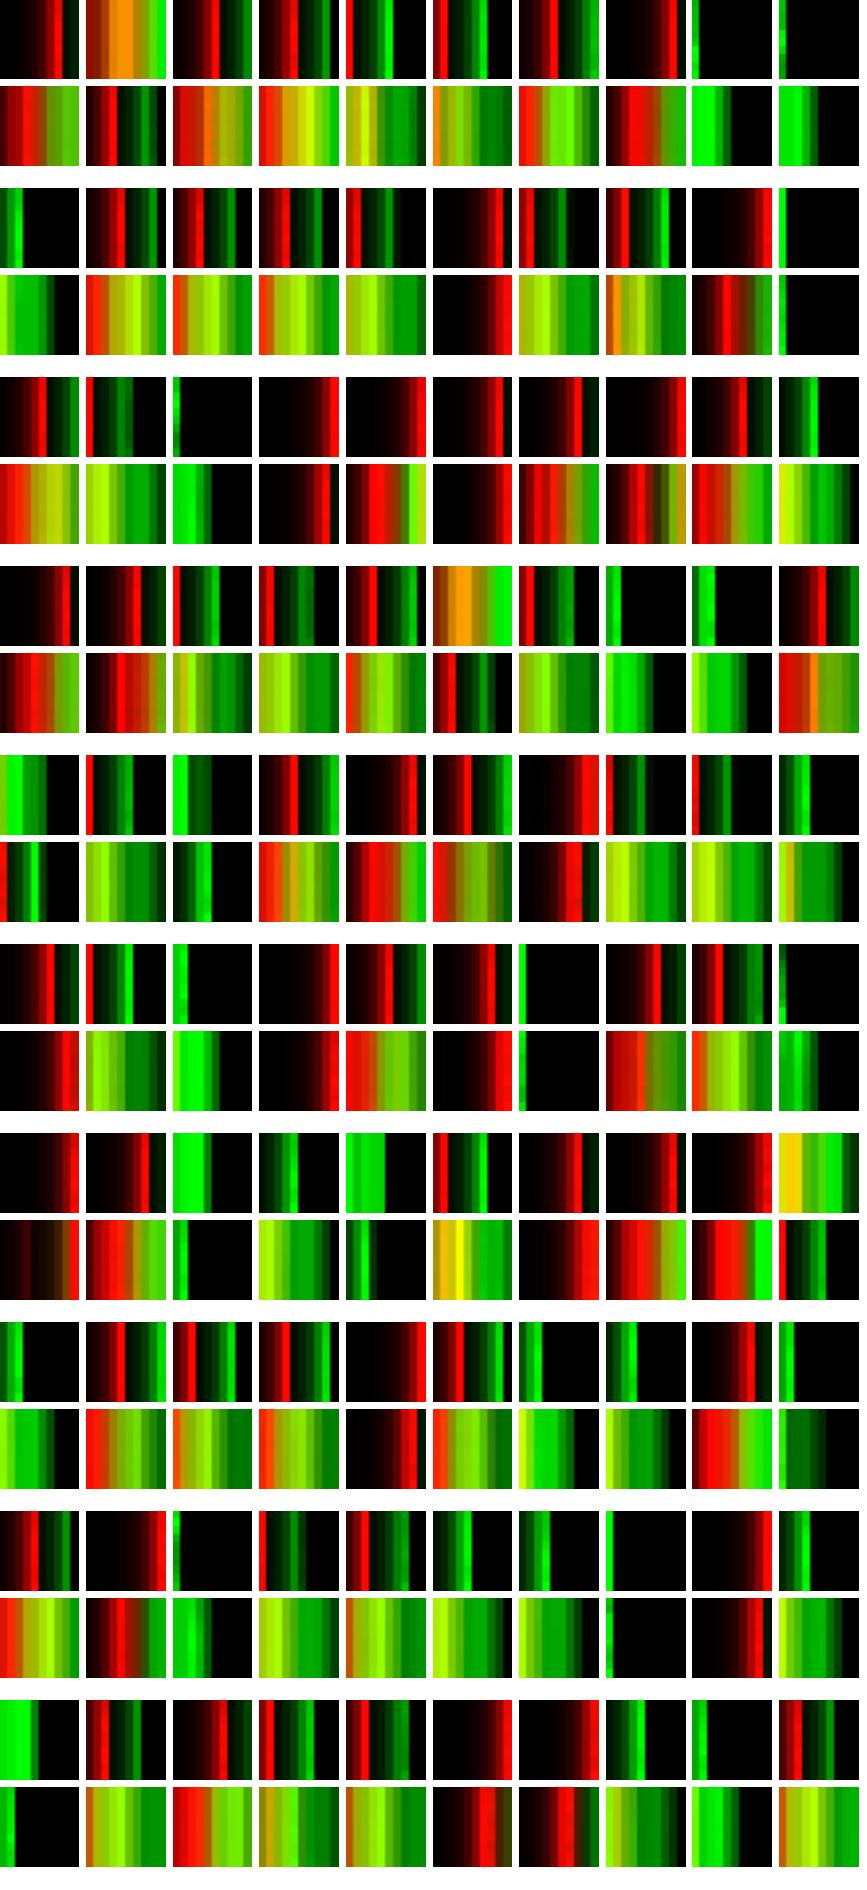

Complex cells weights (average over all simple cells)


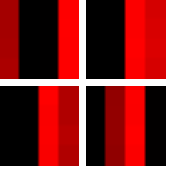

In [76]:
display_network([spinet])

print("Simple cells weights")
if spinet.conf["nbCameras"] == 2:
    display(convert_from_path(network_path + "figures/0/weight_sharing_combined.pdf")[0])
else:
    display(convert_from_path(network_path + "figures/0/weight_sharing_0.pdf")[0])

print("Complex cells weights (average over all simple cells)")
for i in range(spinet.l_shape[1, 2]):
    display(convert_from_path(network_path + "figures/1/complex_weights_depth_" + str(i) + ".pdf")[0])
    break

In [ ]:
import json

network_path = "/home/thomas/Desktop/Experiment/network_0/"
spinet = SpikingNetwork(network_path)
ws = []
cs = []
for i in range(1000):
    weights = []
    confs = []
    for j in range(spinet.l_shape[0][2]):
        w = np.load(network_path + "weights/intermediate_" + str(i) + "/0/" + str(j) + ".npy")
        # with open(network_path + "weights/intermediate_" + str(i) + "/0/" + str(j) + ".json") as file:
        #     confs.append(json.load(file)["count_spike"])
        weights.append(w)
    ws.append(weights)
    cs.append(confs)

    spinet.weights[0] = np.array(weights)
    display_network([spinet])
    shutil.copy(network_path + "figures/0/weight_sharing_combined.pdf", "/home/thomas/Bureau/weights/" + str(i) + ".pdf")

ws = np.array(ws)
cs = np.array(cs)

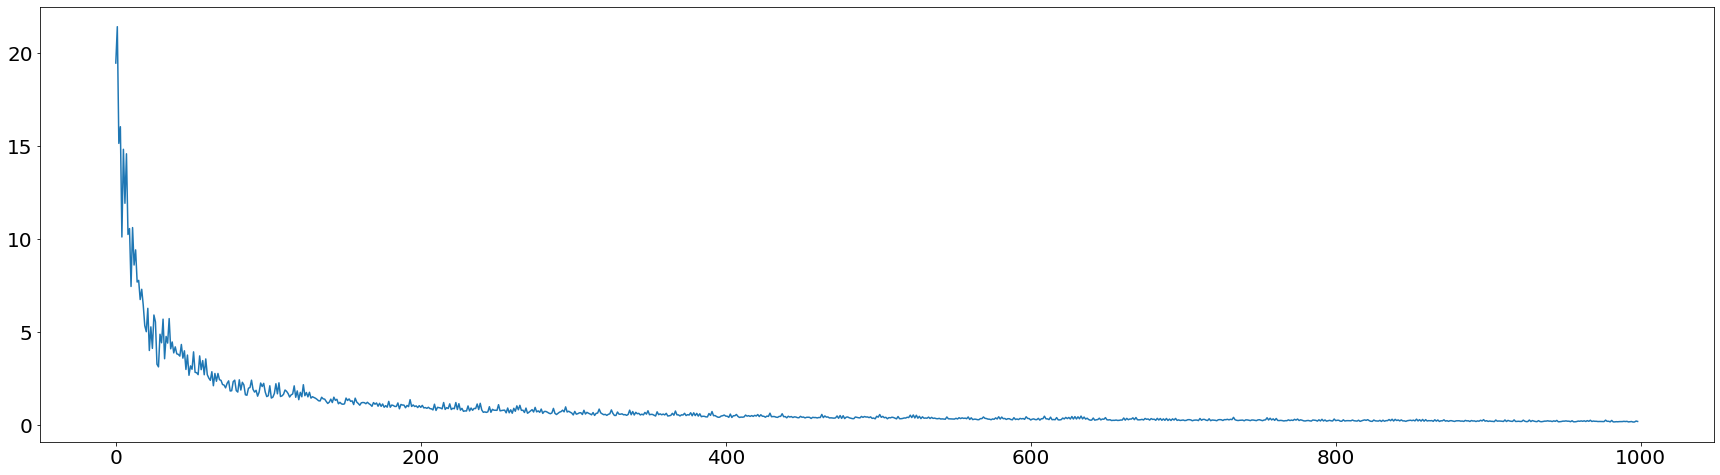

In [78]:
total_sum = np.sum(ws, axis=tuple(np.arange(1, ws.ndim)))
weight_diff = np.abs(np.diff(ws, axis=0))
sum_diff = np.sum(weight_diff, axis=tuple(np.arange(1, weight_diff.ndim)))
plt.plot(100 * sum_diff / total_sum[:-1])
# plt.plot(total_sum)

In [ ]:
# inhibition_weight_against_orientation(spinet)
inhibition_weight_against_disparity(spinet)

## Direction and Orientation selectivity

In [ ]:
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
dir_vec, ori_vec = complex_cells_directions(spinet, rotations)

angles = np.pi * rotations / 180

dirs = []
dis = []
for i in range(len(spinet.neurons[1])):
    dirs.append(direction_norm_length(spinet.directions[:, i], angles))
    dis.append(direction_selectivity(spinet.directions[:, i]))
oris = []
ois = []
for i in range(len(spinet.neurons[1])):
    oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
    ois.append(orientation_selectivity(spinet.orientations[:, i]))

## Disparity selectivity

In [ ]:
plt.imshow(spinet.disparities)
plt.colorbar(orientation='horizontal')

plt.figure()
mean = np.mean(spinet.disparities, axis=1)
plt.plot(mean)

In [ ]:
disparities = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])

dir_vec, ori_vec = complex_cell_disparities(spinet, spinet.disparities, disparities)

# angles = np.pi * rotations / 180
#
# dirs = []
# dis = []
# for i in range(len(spinet.neurons[1])):
#     dirs.append(direction_norm_length(spinet.directions[:, i], angles))
#     dis.append(direction_selectivity(spinet.directions[:, i]))
# oris = []
# ois = []
# for i in range(len(spinet.neurons[1])):
#     oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
#     ois.append(orientation_selectivity(spinet.orientations[:, i]))

## Spike analysis

Displaying information related to spike timings in the network.

This includes:
- Eventplots
- Time histograms
- Inter-spike histograms
- Raster plots
- Instantaneous rates
- Correlation coefficient matrices
- spike rate histograms

In [ ]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    subset = slice(0, len(layer_spike_train))
    print(subset)
    print("Layer " + str(layer + 1) + ", nb neurons = " + str(layer_spike_train[subset].shape[0]) + ":")
    sts = spike_trains(layer_spike_train[subset])
    path = network_path + "figures/"
    raster_plot(sts, layer, path)
    event_plot(sts, layer, path)
    time_histogram(sts, layer, path)
    spike_rate_histogram(layer_spike_train, layer, path)
    # isi_histogram(sts, layer, path)
    instantaneous_rates(sts, layer, path)
    # correlation_coeficient_matrix(sts, layer, path)

#### Compare activity between 2 networks

In [ ]:
network_path1 = "/home/thomas/Desktop/Experiment/EXP3/network_control/"
network_path2 = "/home/thomas/Desktop/Experiment/EXP3/network_experiment/"

spinet = SpikingNetwork(network_path1)
sts_s1 = spike_trains(spinet.spikes[0])
sts_c1 = spike_trains(spinet.spikes[1])

spinet = SpikingNetwork(network_path2)
sts_s2 = spike_trains(spinet.spikes[0])
sts_c2 = spike_trains(spinet.spikes[1])

from scipy.stats import laplace

draw = laplace(0, 1).rvs(size=50)
draw = np.round(draw)

time_histogram_comparison(spinet, sts_s1, sts_s2, draw)
time_histogram_comparison(spinet, sts_c1, sts_c2, draw)

## Compute receptive field disparities

In [ ]:
residuals, disparities = rf_matching(spinet)
disparity_histogram(spinet, disparities)

## Network training information

In [ ]:
reward = np.array(spinet.state["learning_data"]["reward"])
value = np.array(spinet.state["learning_data"]["value"])
value_dot = np.array(spinet.state["learning_data"]["valueDot"])
td_error = np.array(spinet.state["learning_data"]["tdError"])
score = np.array(spinet.state["learning_data"]["score"])
t = np.linspace(0, np.max(spinet.spikes[0]), reward.size) * 1e-6

plt.figure(figsize=(40, 8))
plt.title("Reward and value curves")
plt.xlabel("time (s)")
plt.plot(t, reward, label="reward")
plt.plot(t, value, label="value")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.legend()
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Value derivative")
plt.xlabel("time (s)")
plt.plot(t, value_dot, color="green", label="value_dot")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("TD error")
plt.xlabel("time (s)")
plt.plot(t, td_error, color="red", label="td_error")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

td_actions = []
for i in range(0, td_error.shape[0], 10):
    td_actions.append(np.mean(td_error[i:i + 10]))

plt.figure(figsize=(40, 8))
plt.title("mean TD error at action choice")
plt.xlabel("time (s)")
plt.plot(td_actions, color="cyan", label="td_error")
plt.hlines(0, 0, i / 10, linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Score")
plt.xlabel("time (s)")
plt.plot(10 * np.arange(0, score.shape[0]), score, color="red", label="td_error")
plt.show()

## Policy plot

In [ ]:
actions = np.array(spinet.state["learning_data"]["action"])
exploration = np.array(spinet.state["learning_data"]["exploration"])

t = np.arange(0, 10 * actions.size, 10)

classes = ["Left", "None", "Right"]
markers = ["s", "o"]

plt.figure(figsize=(40, 8))
plt.title("Actions")
plt.xlabel("time (s)")

plt.scatter(t[exploration == 0], np.zeros_like(t)[exploration == 0], c=actions[exploration == 0], marker='1',
            linewidths=15)
plt.scatter(t[exploration == 1], np.zeros_like(t)[exploration == 1], c=actions[exploration == 1], marker='s',
            linewidths=15)

plt.legend(handles=plt.scatter.legend_elements()[0], labels=classes)
plt.show()

## Critic and Actor neurons weights

In [ ]:
w = np.zeros((spinet.neurons[2][0].weights.shape[0], spinet.neurons[2][0].weights.shape[1]))
for neuron in spinet.neurons[2]:
    w += np.sum(neuron.weights, axis=2)
plt.figure(figsize=(18, 8))
plt.title("Critic neurons summed weights")
plt.imshow(w.T)
plt.colorbar(orientation="horizontal")
plt.show()

for i, neuron in enumerate(spinet.neurons[3]):
    plt.figure(figsize=(18, 8))
    if i == 0:
        plt.title("Action: camera to the left")
    else:
        plt.title("Action: camera to the right")
    plt.imshow(np.sum(neuron.weights, axis=2).T)
    plt.colorbar(orientation="horizontal")
    plt.show()

## Event rates

In [9]:
nb_events = np.array(spinet.state["learning_data"]["nbEvents"])[:-1]
t = np.linspace(0, np.max(spinet.spikes[0]), nb_events.size) * 1e-6
plt.figure(figsize=(40, 8))
plt.title("Number of events (every 10ms)")
plt.xlabel("time (s)")
plt.plot(t, nb_events)
plt.show()

## Network configuration parameters

In [8]:
print("Network config:\n")
pprint.pprint(spinet.conf)
for layer in range(len(spinet.neurons)):
    print("\nLayer " + str(layer) + ":\n")
    pprint.pprint(spinet.neurons[layer][0].conf)

## Load various neuron informations

In [ ]:
simpa_decay, compa_decay = load_array_param(spinet, "learning_decay")
simpa_spike, compa_spike = load_array_param(spinet, "count_spike")

# Plot correlations

df = pd.read_csv(home + "Desktop/test/df")
temp = df.drop(columns=["TRACKING", "SYNAPSE_DELAY", "STDP_LEARNING", "MIN_THRESH"])

correlation_matrix(temp.iloc[:, 25:])
scatter_mat(temp.iloc[:, 25:])

## Load and create gabor basis

In [ ]:
basis = spinet.generate_weight_mat()
spinet.generate_weight_images()
gabor_params_l = create_gabor_basis(spinet, "None", nb_ticks=8)
# gabor_params_l = create_gabor_basis(spinet, "left/", nb_ticks=8)
# gabor_params_r = create_gabor_basis(spinet, "right/", nb_ticks=8)

#### Create plots for preferred orientations and directions

In [7]:
oris, oris_r = hists_preferred_orientations(spinet)
plot_preferred_orientations(spinet, oris, oris_r)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'